# Setup
Comment out javascript if jupyter widgets not installed

In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
from pathlib import Path
from dataset import Video

# Create dataset
Creating data for input to the model is a little tricky. Details in the readme.

In [4]:
v_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door3/train') #in jpg format, from included script
a_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door3/labels.json') # in json format, from included script

In [5]:
from dataset_import import get_training_set, get_validation_set, get_test_set
from model import generate_model
class Args:
    dataset = 'kinetics'
    video_path = v_path
    annotation_path = a_path
    
input_args=Args()

In [6]:
from spatial_transforms2 import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, ToTensor)
from temporal_transforms2 import LoopPadding, TemporalRandomCrop
from target_transforms import ClassLabel, VideoID
from target_transforms import Compose as TargetCompose

In [7]:
norm_value=255 #for rgb data

scale_step=0.84089 #for the kinetics dataset
scales = [1]
n_scales=5
for i in range(1, n_scales):
    scales.append(scales[-1] * scale_step)
    
sample_size=112 # default for kinetics
sample_duration=4 # my choosen window size
norm_method = Normalize([110.636/norm_value, 103.1606/norm_value, 96.29/norm_value], 
                        [38.756/norm_value, 37.8824/norm_value, 40.03/norm_value]) #per the averages of the dataset
crop_method = MultiScaleRandomCrop(scales, sample_size)
spatial_transform = Compose([
            crop_method,
            RandomHorizontalFlip(),
            ToTensor(norm_value), norm_method])

In [8]:
temporal_transform = TemporalRandomCrop(sample_duration)
target_transform = ClassLabel()

In [9]:
training_data = get_training_set(input_args, spatial_transform,
                                 temporal_transform, target_transform)

dataset loading [0/191]


In [10]:
batch_size=16 #32 was too large!
n_threads=4
train_loader = torch.utils.data.DataLoader(
            training_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=n_threads,
            pin_memory=True)

# Validation Set
I have one video for training, another for test, and another for validation. Using the ActivityNet data crawler, these videos are easily transformed into the appropriate format as described in the readme.

In [11]:
v_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door3/val')
a_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door3/labels.json')

class Args:
    dataset = 'kinetics'
    video_path = v_path
    annotation_path = a_path
    n_val_samples=5
    sample_duration=4
    
val_args=Args()

In [12]:
validation_data = get_validation_set(
    val_args, spatial_transform, temporal_transform, target_transform)

dataset loading [0/56]


In [13]:
val_loader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True)

# Load Pre-Trained Model
### First, import kinetics pretrained model exactly as is

In [14]:
from models import resnet, pre_act_resnet, wide_resnet, resnext, densenet
import torch.nn as nn

model = resnext.resnet101(
    sample_size=112, #height and width of inputs
    sample_duration=4, #temporal, 16!!!
    num_classes=400) 

In [15]:
#from opts import parse_opts
from model import generate_model
class Args:
    sample_size = 112
    sample_duration = 4 #16!!!
    n_classes = 400
    mode='feature'
    model_name='resnext'
    model_depth=101
    resnet_shortcut='B'
    resnext_cardinality=32
    no_cuda=False
    batch_size=16
    n_threads=4

opt=Args()
model=generate_model(opt)

pretrain_path=Path('/media/tris/tris_files/github/csce_courses/video-classification-3d-cnn-pytorch/resnext-101-kinetics.pth')
model_data = torch.load(pretrain_path)
model.load_state_dict(model_data['state_dict'])
model.eval()

DataParallel(
  (module): ResNeXt(
    (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNeXtBottleneck(
        (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
        (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### With the model correcly imported, add a final layer to reduce the output size to my three desired outputs

In [16]:
for param in model.parameters():
    param.requires_grad = False
#     # Replace the last fully-connected layer
#     # Parameters of newly constructed modules have requires_grad=True by default
# model.fc = nn.Sequential(
#     nn.Linear(400, 256), #256 is arbitrary
#     nn.ReLU(),
#     nn.Linear(256,3),
#     nn.LogSoftmax(dim=1))
# model.fc.requires_grad=True
# model.cuda()
# model.eval()


In [17]:
my_module = nn.Sequential(
    nn.Linear(2048, 1200), #256 is arbitrary
    nn.ReLU(),
    nn.Linear(1200,256),
    nn.ReLU(),
    nn.Linear(256,3))
    #nn.Softmax(dim=1))#dim consider putting the softmax back in, unsure of dimension

In [18]:
my_model = nn.Sequential(model, my_module) #combining the pre-trained and new model
my_model.cuda() #put it on the gpu
my_model.eval()

Sequential(
  (0): DataParallel(
    (module): ResNeXt(
      (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): ResNeXtBottleneck(
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
          (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine

### We now have the original model, plus a few extra layers to resize the output

In [19]:
from torch import optim# Loss and optimizer
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss()
criterion=criterion.cuda()

dampening=0 #0.9
optimizer = optim.SGD(
            my_model.parameters(),
            lr=3e-3,
            momentum=0.9,
            dampening=dampening,
            weight_decay=1e-3, #1e-3 #how important is this if I'm only training the last few layers? Set to 0?
            nesterov=False)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience=10)
# Definatley need some tuning here
    

In [20]:
from utils import Logger
import os
results_path=Path('/media/tris/tris_files/github/csce_courses/')

train_logger = Logger(os.path.join(results_path, 'train.log'),
                      ['epoch', 'loss', 'acc', 'lr'])
train_batch_logger = Logger(os.path.join(results_path, 'train_batch.log'),
                            ['epoch', 'batch', 'iter', 'loss', 'acc', 'lr'])
val_logger = Logger(
            os.path.join(results_path, 'val.log'), ['epoch', 'loss', 'acc'])

In [21]:
begin_epoch=1
n_epoch=100
from train2 import train_epoch
from validation import val_epoch

for i in range(begin_epoch, n_epoch + 1):
    train_epoch(i, train_loader, my_model, criterion, optimizer, opt,
                    train_logger, train_batch_logger)
    validation_loss = val_epoch(i, val_loader, my_model, criterion, opt,
                                    val_logger)
    scheduler.step(validation_loss)

train at epoch 1
Epoch: [1][1/12]	Time 0.741 (0.741)	Data 0.399 (0.399)	Loss 1.1038 (1.1038)	Acc 0.250 (0.250)
Epoch: [1][2/12]	Time 0.031 (0.386)	Data 0.003 (0.201)	Loss 1.0988 (1.1013)	Acc 0.250 (0.250)
Epoch: [1][3/12]	Time 0.112 (0.295)	Data 0.083 (0.162)	Loss 1.0926 (1.0984)	Acc 0.562 (0.354)
Epoch: [1][4/12]	Time 0.088 (0.243)	Data 0.062 (0.137)	Loss 1.0789 (1.0935)	Acc 0.750 (0.453)
Epoch: [1][5/12]	Time 0.083 (0.211)	Data 0.057 (0.121)	Loss 1.0592 (1.0866)	Acc 0.688 (0.500)
Epoch: [1][6/12]	Time 0.081 (0.189)	Data 0.056 (0.110)	Loss 1.0434 (1.0794)	Acc 0.688 (0.531)
Epoch: [1][7/12]	Time 0.083 (0.174)	Data 0.058 (0.103)	Loss 1.0623 (1.0770)	Acc 0.562 (0.536)
Epoch: [1][8/12]	Time 0.079 (0.162)	Data 0.054 (0.096)	Loss 1.0185 (1.0697)	Acc 0.688 (0.555)
Epoch: [1][9/12]	Time 0.083 (0.153)	Data 0.056 (0.092)	Loss 0.9702 (1.0586)	Acc 0.812 (0.583)
Epoch: [1][10/12]	Time 0.085 (0.147)	Data 0.059 (0.089)	Loss 0.9787 (1.0506)	Acc 0.688 (0.594)
Epoch: [1][11/12]	Time 0.083 (0.141)	Data 

Epoch: [3][16/18]	Time 0.073 (0.083)	Data 0.053 (0.062)	Loss 0.9290 (0.9453)	Acc 0.625 (0.645)
Epoch: [3][17/18]	Time 0.075 (0.083)	Data 0.054 (0.062)	Loss 0.9592 (0.9461)	Acc 0.625 (0.643)
Epoch: [3][18/18]	Time 0.075 (0.082)	Data 0.055 (0.061)	Loss 0.9582 (0.9465)	Acc 0.625 (0.643)
train at epoch 4
Epoch: [4][1/12]	Time 0.374 (0.374)	Data 0.347 (0.347)	Loss 0.7274 (0.7274)	Acc 0.750 (0.750)
Epoch: [4][2/12]	Time 0.079 (0.227)	Data 0.051 (0.199)	Loss 0.7665 (0.7469)	Acc 0.750 (0.750)
Epoch: [4][3/12]	Time 0.077 (0.177)	Data 0.052 (0.150)	Loss 0.7898 (0.7612)	Acc 0.688 (0.729)
Epoch: [4][4/12]	Time 0.078 (0.152)	Data 0.053 (0.126)	Loss 0.8210 (0.7762)	Acc 0.688 (0.719)
Epoch: [4][5/12]	Time 0.081 (0.138)	Data 0.056 (0.112)	Loss 0.6308 (0.7471)	Acc 0.812 (0.738)
Epoch: [4][6/12]	Time 0.078 (0.128)	Data 0.053 (0.102)	Loss 0.5405 (0.7127)	Acc 0.875 (0.760)
Epoch: [4][7/12]	Time 0.079 (0.121)	Data 0.054 (0.095)	Loss 0.9918 (0.7525)	Acc 0.562 (0.732)
Epoch: [4][8/12]	Time 0.079 (0.116)	Data

Epoch: [6][13/18]	Time 0.076 (0.085)	Data 0.056 (0.064)	Loss 1.3302 (0.8576)	Acc 0.312 (0.649)
Epoch: [6][14/18]	Time 0.075 (0.084)	Data 0.055 (0.063)	Loss 0.9263 (0.8626)	Acc 0.625 (0.647)
Epoch: [6][15/18]	Time 0.075 (0.084)	Data 0.055 (0.063)	Loss 0.9360 (0.8675)	Acc 0.625 (0.646)
Epoch: [6][16/18]	Time 0.073 (0.083)	Data 0.054 (0.062)	Loss 0.9145 (0.8704)	Acc 0.625 (0.645)
Epoch: [6][17/18]	Time 0.076 (0.083)	Data 0.056 (0.062)	Loss 0.9417 (0.8746)	Acc 0.625 (0.643)
Epoch: [6][18/18]	Time 0.075 (0.082)	Data 0.055 (0.061)	Loss 0.9656 (0.8772)	Acc 0.625 (0.643)
train at epoch 7
Epoch: [7][1/12]	Time 0.391 (0.391)	Data 0.362 (0.362)	Loss 1.0331 (1.0331)	Acc 0.500 (0.500)
Epoch: [7][2/12]	Time 0.076 (0.234)	Data 0.052 (0.207)	Loss 1.0645 (1.0488)	Acc 0.500 (0.500)
Epoch: [7][3/12]	Time 0.079 (0.182)	Data 0.055 (0.156)	Loss 0.7363 (0.9446)	Acc 0.688 (0.562)
Epoch: [7][4/12]	Time 0.082 (0.157)	Data 0.055 (0.131)	Loss 0.7260 (0.8899)	Acc 0.688 (0.594)
Epoch: [7][5/12]	Time 0.086 (0.143)	D

Epoch: [9][10/18]	Time 0.075 (0.089)	Data 0.055 (0.067)	Loss 1.2583 (0.7144)	Acc 0.375 (0.719)
Epoch: [9][11/18]	Time 0.074 (0.088)	Data 0.054 (0.066)	Loss 1.3406 (0.7713)	Acc 0.375 (0.688)
Epoch: [9][12/18]	Time 0.075 (0.087)	Data 0.056 (0.065)	Loss 1.0246 (0.7925)	Acc 0.562 (0.677)
Epoch: [9][13/18]	Time 0.073 (0.086)	Data 0.054 (0.064)	Loss 1.1876 (0.8229)	Acc 0.312 (0.649)
Epoch: [9][14/18]	Time 0.074 (0.085)	Data 0.055 (0.064)	Loss 0.8683 (0.8261)	Acc 0.625 (0.647)
Epoch: [9][15/18]	Time 0.073 (0.084)	Data 0.054 (0.063)	Loss 0.9782 (0.8362)	Acc 0.625 (0.646)
Epoch: [9][16/18]	Time 0.076 (0.084)	Data 0.056 (0.063)	Loss 0.9663 (0.8444)	Acc 0.625 (0.645)
Epoch: [9][17/18]	Time 0.075 (0.083)	Data 0.055 (0.062)	Loss 0.8191 (0.8429)	Acc 0.625 (0.643)
Epoch: [9][18/18]	Time 0.076 (0.083)	Data 0.056 (0.062)	Loss 0.8086 (0.8419)	Acc 0.625 (0.643)
train at epoch 10
Epoch: [10][1/12]	Time 0.296 (0.296)	Data 0.265 (0.265)	Loss 0.7322 (0.7322)	Acc 0.688 (0.688)
Epoch: [10][2/12]	Time 0.081 (0.

Epoch: [12][7/18]	Time 0.077 (0.098)	Data 0.056 (0.076)	Loss 0.7297 (0.6606)	Acc 0.875 (0.768)
Epoch: [12][8/18]	Time 0.079 (0.096)	Data 0.058 (0.073)	Loss 1.0744 (0.7123)	Acc 0.562 (0.742)
Epoch: [12][9/18]	Time 0.076 (0.094)	Data 0.055 (0.071)	Loss 0.1978 (0.6552)	Acc 1.000 (0.771)
Epoch: [12][10/18]	Time 0.076 (0.092)	Data 0.055 (0.070)	Loss 1.0666 (0.6963)	Acc 0.500 (0.744)
Epoch: [12][11/18]	Time 0.075 (0.090)	Data 0.056 (0.068)	Loss 1.2148 (0.7434)	Acc 0.375 (0.710)
Epoch: [12][12/18]	Time 0.075 (0.089)	Data 0.055 (0.067)	Loss 0.8845 (0.7552)	Acc 0.750 (0.714)
Epoch: [12][13/18]	Time 0.077 (0.088)	Data 0.057 (0.066)	Loss 1.1070 (0.7823)	Acc 0.375 (0.688)
Epoch: [12][14/18]	Time 0.078 (0.087)	Data 0.058 (0.066)	Loss 0.7811 (0.7822)	Acc 0.688 (0.688)
Epoch: [12][15/18]	Time 0.076 (0.087)	Data 0.056 (0.065)	Loss 0.9447 (0.7930)	Acc 0.688 (0.688)
Epoch: [12][16/18]	Time 0.076 (0.086)	Data 0.056 (0.065)	Loss 0.7974 (0.7933)	Acc 0.562 (0.680)
Epoch: [12][17/18]	Time 0.075 (0.085)	Data 

Epoch: [15][4/18]	Time 0.074 (0.110)	Data 0.053 (0.084)	Loss 0.6763 (0.6628)	Acc 0.625 (0.719)
Epoch: [15][5/18]	Time 0.074 (0.103)	Data 0.053 (0.078)	Loss 0.8029 (0.6908)	Acc 0.688 (0.713)
Epoch: [15][6/18]	Time 0.074 (0.098)	Data 0.053 (0.074)	Loss 0.3437 (0.6330)	Acc 1.000 (0.760)
Epoch: [15][7/18]	Time 0.076 (0.095)	Data 0.055 (0.071)	Loss 0.7224 (0.6457)	Acc 0.688 (0.750)
Epoch: [15][8/18]	Time 0.080 (0.093)	Data 0.059 (0.070)	Loss 0.9239 (0.6805)	Acc 0.562 (0.727)
Epoch: [15][9/18]	Time 0.078 (0.091)	Data 0.057 (0.068)	Loss 0.1235 (0.6186)	Acc 1.000 (0.757)
Epoch: [15][10/18]	Time 0.079 (0.090)	Data 0.059 (0.067)	Loss 1.1098 (0.6677)	Acc 0.438 (0.725)
Epoch: [15][11/18]	Time 0.078 (0.089)	Data 0.059 (0.067)	Loss 1.2641 (0.7220)	Acc 0.375 (0.693)
Epoch: [15][12/18]	Time 0.078 (0.088)	Data 0.058 (0.066)	Loss 0.7392 (0.7234)	Acc 0.625 (0.688)
Epoch: [15][13/18]	Time 0.079 (0.087)	Data 0.060 (0.065)	Loss 1.0124 (0.7456)	Acc 0.625 (0.683)
Epoch: [15][14/18]	Time 0.079 (0.087)	Data 0.0

Epoch: [18][1/18]	Time 0.221 (0.221)	Data 0.196 (0.196)	Loss 0.3449 (0.3449)	Acc 0.938 (0.938)
Epoch: [18][2/18]	Time 0.077 (0.149)	Data 0.050 (0.123)	Loss 0.9080 (0.6265)	Acc 0.500 (0.719)
Epoch: [18][3/18]	Time 0.069 (0.122)	Data 0.049 (0.099)	Loss 0.6052 (0.6194)	Acc 0.812 (0.750)
Epoch: [18][4/18]	Time 0.075 (0.110)	Data 0.055 (0.088)	Loss 0.5915 (0.6124)	Acc 0.625 (0.719)
Epoch: [18][5/18]	Time 0.074 (0.103)	Data 0.054 (0.081)	Loss 0.8342 (0.6568)	Acc 0.688 (0.713)
Epoch: [18][6/18]	Time 0.081 (0.100)	Data 0.059 (0.077)	Loss 0.3669 (0.6084)	Acc 1.000 (0.760)
Epoch: [18][7/18]	Time 0.079 (0.097)	Data 0.057 (0.074)	Loss 0.7168 (0.6239)	Acc 0.688 (0.750)
Epoch: [18][8/18]	Time 0.079 (0.094)	Data 0.057 (0.072)	Loss 0.9537 (0.6652)	Acc 0.688 (0.742)
Epoch: [18][9/18]	Time 0.085 (0.093)	Data 0.057 (0.070)	Loss 0.0899 (0.6012)	Acc 1.000 (0.771)
Epoch: [18][10/18]	Time 0.076 (0.092)	Data 0.056 (0.069)	Loss 1.0398 (0.6451)	Acc 0.562 (0.750)
Epoch: [18][11/18]	Time 0.079 (0.090)	Data 0.059 

Epoch: [21][10/12]	Time 0.081 (0.110)	Data 0.051 (0.080)	Loss 0.8659 (0.7298)	Acc 0.625 (0.725)
Epoch: [21][11/12]	Time 0.080 (0.107)	Data 0.049 (0.078)	Loss 0.5427 (0.7128)	Acc 0.812 (0.733)
Epoch: [21][12/12]	Time 0.077 (0.105)	Data 0.049 (0.075)	Loss 0.6451 (0.7075)	Acc 0.800 (0.738)
validation at epoch 21
Epoch: [21][1/18]	Time 0.267 (0.267)	Data 0.238 (0.238)	Loss 0.3748 (0.3748)	Acc 0.875 (0.875)
Epoch: [21][2/18]	Time 0.104 (0.186)	Data 0.046 (0.142)	Loss 0.9301 (0.6525)	Acc 0.562 (0.719)
Epoch: [21][3/18]	Time 0.039 (0.137)	Data 0.016 (0.100)	Loss 0.5724 (0.6258)	Acc 0.875 (0.771)
Epoch: [21][4/18]	Time 0.072 (0.121)	Data 0.051 (0.088)	Loss 0.5865 (0.6160)	Acc 0.812 (0.781)
Epoch: [21][5/18]	Time 0.076 (0.112)	Data 0.055 (0.081)	Loss 0.7545 (0.6437)	Acc 0.688 (0.762)
Epoch: [21][6/18]	Time 0.086 (0.108)	Data 0.063 (0.078)	Loss 0.3842 (0.6004)	Acc 0.938 (0.792)
Epoch: [21][7/18]	Time 0.079 (0.103)	Data 0.057 (0.075)	Loss 0.6731 (0.6108)	Acc 0.750 (0.786)
Epoch: [21][8/18]	Time 0

Epoch: [24][7/12]	Time 0.073 (0.115)	Data 0.049 (0.087)	Loss 0.8445 (0.6676)	Acc 0.625 (0.732)
Epoch: [24][8/12]	Time 0.080 (0.111)	Data 0.055 (0.083)	Loss 0.8793 (0.6941)	Acc 0.562 (0.711)
Epoch: [24][9/12]	Time 0.084 (0.108)	Data 0.060 (0.081)	Loss 0.4578 (0.6678)	Acc 0.812 (0.722)
Epoch: [24][10/12]	Time 0.086 (0.106)	Data 0.062 (0.079)	Loss 0.6558 (0.6666)	Acc 0.750 (0.725)
Epoch: [24][11/12]	Time 0.087 (0.104)	Data 0.062 (0.077)	Loss 0.5109 (0.6525)	Acc 0.812 (0.733)
Epoch: [24][12/12]	Time 0.087 (0.103)	Data 0.062 (0.076)	Loss 0.5665 (0.6457)	Acc 0.867 (0.743)
validation at epoch 24
Epoch: [24][1/18]	Time 0.230 (0.230)	Data 0.203 (0.203)	Loss 0.2311 (0.2311)	Acc 0.938 (0.938)
Epoch: [24][2/18]	Time 0.078 (0.154)	Data 0.050 (0.126)	Loss 0.8895 (0.5603)	Acc 0.750 (0.844)
Epoch: [24][3/18]	Time 0.068 (0.125)	Data 0.047 (0.100)	Loss 0.5956 (0.5721)	Acc 0.812 (0.833)
Epoch: [24][4/18]	Time 0.075 (0.113)	Data 0.054 (0.088)	Loss 0.5950 (0.5778)	Acc 0.812 (0.828)
Epoch: [24][5/18]	Time 0

Epoch: [27][4/12]	Time 0.080 (0.149)	Data 0.053 (0.122)	Loss 0.6596 (0.6448)	Acc 0.688 (0.734)
Epoch: [27][5/12]	Time 0.077 (0.135)	Data 0.052 (0.108)	Loss 0.6088 (0.6376)	Acc 0.750 (0.738)
Epoch: [27][6/12]	Time 0.078 (0.125)	Data 0.053 (0.099)	Loss 0.9141 (0.6837)	Acc 0.562 (0.708)
Epoch: [27][7/12]	Time 0.080 (0.119)	Data 0.054 (0.092)	Loss 0.5056 (0.6582)	Acc 0.812 (0.723)
Epoch: [27][8/12]	Time 0.077 (0.114)	Data 0.053 (0.087)	Loss 0.6258 (0.6542)	Acc 0.688 (0.719)
Epoch: [27][9/12]	Time 0.078 (0.110)	Data 0.054 (0.084)	Loss 0.8197 (0.6726)	Acc 0.688 (0.715)
Epoch: [27][10/12]	Time 0.077 (0.106)	Data 0.054 (0.081)	Loss 0.4959 (0.6549)	Acc 0.688 (0.713)
Epoch: [27][11/12]	Time 0.079 (0.104)	Data 0.055 (0.078)	Loss 0.7219 (0.6610)	Acc 0.688 (0.710)
Epoch: [27][12/12]	Time 0.078 (0.102)	Data 0.054 (0.076)	Loss 0.5851 (0.6550)	Acc 0.733 (0.712)
validation at epoch 27
Epoch: [27][1/18]	Time 0.239 (0.239)	Data 0.205 (0.205)	Loss 0.3760 (0.3760)	Acc 0.938 (0.938)
Epoch: [27][2/18]	Time 0

Epoch: [30][1/12]	Time 0.336 (0.336)	Data 0.307 (0.307)	Loss 0.7384 (0.7384)	Acc 0.688 (0.688)
Epoch: [30][2/12]	Time 0.076 (0.206)	Data 0.050 (0.178)	Loss 0.7625 (0.7504)	Acc 0.625 (0.656)
Epoch: [30][3/12]	Time 0.077 (0.163)	Data 0.053 (0.136)	Loss 0.6292 (0.7100)	Acc 0.812 (0.708)
Epoch: [30][4/12]	Time 0.078 (0.142)	Data 0.054 (0.116)	Loss 0.7986 (0.7322)	Acc 0.688 (0.703)
Epoch: [30][5/12]	Time 0.079 (0.129)	Data 0.053 (0.103)	Loss 0.4893 (0.6836)	Acc 0.812 (0.725)
Epoch: [30][6/12]	Time 0.079 (0.121)	Data 0.053 (0.095)	Loss 0.5871 (0.6675)	Acc 0.625 (0.708)
Epoch: [30][7/12]	Time 0.077 (0.114)	Data 0.053 (0.089)	Loss 0.5342 (0.6485)	Acc 0.750 (0.714)
Epoch: [30][8/12]	Time 0.078 (0.110)	Data 0.054 (0.085)	Loss 0.5465 (0.6357)	Acc 0.812 (0.727)
Epoch: [30][9/12]	Time 0.078 (0.106)	Data 0.054 (0.081)	Loss 1.0691 (0.6839)	Acc 0.625 (0.715)
Epoch: [30][10/12]	Time 0.079 (0.104)	Data 0.054 (0.078)	Loss 0.4576 (0.6613)	Acc 0.750 (0.719)
Epoch: [30][11/12]	Time 0.079 (0.101)	Data 0.056 

Epoch: [32][16/18]	Time 0.073 (0.082)	Data 0.054 (0.062)	Loss 0.7951 (0.7660)	Acc 0.625 (0.730)
Epoch: [32][17/18]	Time 0.074 (0.082)	Data 0.055 (0.062)	Loss 0.8029 (0.7682)	Acc 0.688 (0.728)
Epoch: [32][18/18]	Time 0.073 (0.081)	Data 0.055 (0.061)	Loss 0.6379 (0.7644)	Acc 1.000 (0.736)
train at epoch 33
Epoch: [33][1/12]	Time 0.285 (0.285)	Data 0.257 (0.257)	Loss 0.8244 (0.8244)	Acc 0.625 (0.625)
Epoch: [33][2/12]	Time 0.075 (0.180)	Data 0.051 (0.154)	Loss 0.6873 (0.7559)	Acc 0.625 (0.625)
Epoch: [33][3/12]	Time 0.079 (0.147)	Data 0.054 (0.120)	Loss 0.7962 (0.7693)	Acc 0.750 (0.667)
Epoch: [33][4/12]	Time 0.080 (0.130)	Data 0.052 (0.103)	Loss 0.7619 (0.7675)	Acc 0.625 (0.656)
Epoch: [33][5/12]	Time 0.077 (0.119)	Data 0.050 (0.093)	Loss 0.6382 (0.7416)	Acc 0.750 (0.675)
Epoch: [33][6/12]	Time 0.078 (0.112)	Data 0.052 (0.086)	Loss 0.3692 (0.6795)	Acc 0.875 (0.708)
Epoch: [33][7/12]	Time 0.076 (0.107)	Data 0.052 (0.081)	Loss 0.9195 (0.7138)	Acc 0.625 (0.696)
Epoch: [33][8/12]	Time 0.078 

Epoch: [35][13/18]	Time 0.074 (0.092)	Data 0.054 (0.070)	Loss 1.0051 (0.7522)	Acc 0.562 (0.707)
Epoch: [35][14/18]	Time 0.075 (0.091)	Data 0.056 (0.069)	Loss 0.8577 (0.7597)	Acc 0.625 (0.701)
Epoch: [35][15/18]	Time 0.079 (0.090)	Data 0.060 (0.069)	Loss 0.8039 (0.7627)	Acc 0.750 (0.704)
Epoch: [35][16/18]	Time 0.076 (0.090)	Data 0.056 (0.068)	Loss 0.7360 (0.7610)	Acc 0.688 (0.703)
Epoch: [35][17/18]	Time 0.074 (0.089)	Data 0.054 (0.067)	Loss 0.7743 (0.7618)	Acc 0.688 (0.702)
Epoch: [35][18/18]	Time 0.074 (0.088)	Data 0.055 (0.066)	Loss 0.7307 (0.7609)	Acc 0.875 (0.707)
train at epoch 36
Epoch: [36][1/12]	Time 0.270 (0.270)	Data 0.239 (0.239)	Loss 0.8620 (0.8620)	Acc 0.625 (0.625)
Epoch: [36][2/12]	Time 0.079 (0.175)	Data 0.054 (0.146)	Loss 0.7870 (0.8245)	Acc 0.812 (0.719)
Epoch: [36][3/12]	Time 0.086 (0.145)	Data 0.060 (0.118)	Loss 1.1300 (0.9263)	Acc 0.500 (0.646)
Epoch: [36][4/12]	Time 0.083 (0.130)	Data 0.058 (0.103)	Loss 0.7585 (0.8844)	Acc 0.750 (0.672)
Epoch: [36][5/12]	Time 0.0

Epoch: [38][10/18]	Time 0.074 (0.088)	Data 0.054 (0.066)	Loss 1.1376 (0.6408)	Acc 0.750 (0.775)
Epoch: [38][11/18]	Time 0.074 (0.086)	Data 0.055 (0.065)	Loss 1.0908 (0.6817)	Acc 0.375 (0.739)
Epoch: [38][12/18]	Time 0.073 (0.085)	Data 0.054 (0.064)	Loss 0.8465 (0.6955)	Acc 0.812 (0.745)
Epoch: [38][13/18]	Time 0.073 (0.084)	Data 0.054 (0.064)	Loss 1.2123 (0.7352)	Acc 0.438 (0.721)
Epoch: [38][14/18]	Time 0.075 (0.084)	Data 0.055 (0.063)	Loss 0.7681 (0.7376)	Acc 0.625 (0.714)
Epoch: [38][15/18]	Time 0.073 (0.083)	Data 0.054 (0.062)	Loss 0.9059 (0.7488)	Acc 0.688 (0.713)
Epoch: [38][16/18]	Time 0.074 (0.082)	Data 0.054 (0.062)	Loss 0.8656 (0.7561)	Acc 0.562 (0.703)
Epoch: [38][17/18]	Time 0.075 (0.082)	Data 0.055 (0.062)	Loss 0.7304 (0.7546)	Acc 0.625 (0.699)
Epoch: [38][18/18]	Time 0.073 (0.081)	Data 0.054 (0.061)	Loss 0.8337 (0.7569)	Acc 0.625 (0.696)
train at epoch 39
Epoch: [39][1/12]	Time 0.310 (0.310)	Data 0.279 (0.279)	Loss 0.5784 (0.5784)	Acc 0.812 (0.812)
Epoch: [39][2/12]	Time 

Epoch: [41][7/18]	Time 0.074 (0.094)	Data 0.054 (0.073)	Loss 0.6439 (0.6040)	Acc 0.688 (0.741)
Epoch: [41][8/18]	Time 0.074 (0.092)	Data 0.054 (0.071)	Loss 0.9589 (0.6484)	Acc 0.625 (0.727)
Epoch: [41][9/18]	Time 0.074 (0.090)	Data 0.054 (0.069)	Loss 0.1327 (0.5911)	Acc 1.000 (0.757)
Epoch: [41][10/18]	Time 0.074 (0.088)	Data 0.054 (0.067)	Loss 1.1693 (0.6489)	Acc 0.625 (0.744)
Epoch: [41][11/18]	Time 0.075 (0.087)	Data 0.055 (0.066)	Loss 1.2439 (0.7030)	Acc 0.375 (0.710)
Epoch: [41][12/18]	Time 0.073 (0.086)	Data 0.054 (0.065)	Loss 0.9359 (0.7224)	Acc 0.812 (0.719)
Epoch: [41][13/18]	Time 0.073 (0.085)	Data 0.054 (0.064)	Loss 1.1900 (0.7584)	Acc 0.500 (0.702)
Epoch: [41][14/18]	Time 0.075 (0.084)	Data 0.056 (0.064)	Loss 0.8164 (0.7625)	Acc 0.625 (0.696)
Epoch: [41][15/18]	Time 0.073 (0.083)	Data 0.054 (0.063)	Loss 0.9506 (0.7750)	Acc 0.688 (0.696)
Epoch: [41][16/18]	Time 0.073 (0.083)	Data 0.055 (0.063)	Loss 0.6750 (0.7688)	Acc 0.812 (0.703)
Epoch: [41][17/18]	Time 0.075 (0.082)	Data 

Epoch: [44][4/18]	Time 0.073 (0.109)	Data 0.053 (0.085)	Loss 0.5760 (0.6139)	Acc 0.750 (0.734)
Epoch: [44][5/18]	Time 0.074 (0.102)	Data 0.054 (0.079)	Loss 0.7450 (0.6401)	Acc 0.750 (0.738)
Epoch: [44][6/18]	Time 0.073 (0.097)	Data 0.053 (0.075)	Loss 0.2426 (0.5739)	Acc 1.000 (0.781)
Epoch: [44][7/18]	Time 0.073 (0.094)	Data 0.054 (0.072)	Loss 0.6201 (0.5805)	Acc 0.750 (0.777)
Epoch: [44][8/18]	Time 0.075 (0.092)	Data 0.055 (0.070)	Loss 0.9649 (0.6285)	Acc 0.625 (0.758)
Epoch: [44][9/18]	Time 0.074 (0.090)	Data 0.053 (0.068)	Loss 0.1145 (0.5714)	Acc 1.000 (0.785)
Epoch: [44][10/18]	Time 0.074 (0.088)	Data 0.053 (0.066)	Loss 1.1797 (0.6322)	Acc 0.625 (0.769)
Epoch: [44][11/18]	Time 0.074 (0.087)	Data 0.054 (0.065)	Loss 1.1821 (0.6822)	Acc 0.375 (0.733)
Epoch: [44][12/18]	Time 0.073 (0.086)	Data 0.054 (0.064)	Loss 0.9392 (0.7036)	Acc 0.812 (0.740)
Epoch: [44][13/18]	Time 0.073 (0.085)	Data 0.054 (0.064)	Loss 1.1128 (0.7351)	Acc 0.500 (0.721)
Epoch: [44][14/18]	Time 0.075 (0.084)	Data 0.0

Epoch: [47][1/18]	Time 0.240 (0.240)	Data 0.208 (0.208)	Loss 0.2683 (0.2683)	Acc 0.938 (0.938)
Epoch: [47][2/18]	Time 0.082 (0.161)	Data 0.050 (0.129)	Loss 0.8518 (0.5601)	Acc 0.562 (0.750)
Epoch: [47][3/18]	Time 0.068 (0.130)	Data 0.047 (0.102)	Loss 0.6834 (0.6012)	Acc 0.812 (0.771)
Epoch: [47][4/18]	Time 0.077 (0.117)	Data 0.056 (0.090)	Loss 0.5953 (0.5997)	Acc 0.688 (0.750)
Epoch: [47][5/18]	Time 0.078 (0.109)	Data 0.057 (0.084)	Loss 0.6983 (0.6194)	Acc 0.750 (0.750)
Epoch: [47][6/18]	Time 0.080 (0.104)	Data 0.059 (0.080)	Loss 0.3219 (0.5698)	Acc 0.938 (0.781)
Epoch: [47][7/18]	Time 0.076 (0.100)	Data 0.056 (0.076)	Loss 0.6985 (0.5882)	Acc 0.750 (0.777)
Epoch: [47][8/18]	Time 0.076 (0.097)	Data 0.055 (0.074)	Loss 0.9426 (0.6325)	Acc 0.688 (0.766)
Epoch: [47][9/18]	Time 0.078 (0.095)	Data 0.057 (0.072)	Loss 0.0965 (0.5730)	Acc 1.000 (0.792)
Epoch: [47][10/18]	Time 0.073 (0.093)	Data 0.053 (0.070)	Loss 1.1179 (0.6274)	Acc 0.625 (0.775)
Epoch: [47][11/18]	Time 0.074 (0.091)	Data 0.054 

Epoch: [50][10/12]	Time 0.079 (0.097)	Data 0.056 (0.072)	Loss 0.4502 (0.6788)	Acc 0.812 (0.725)
Epoch: [50][11/12]	Time 0.079 (0.095)	Data 0.056 (0.070)	Loss 0.3953 (0.6530)	Acc 0.812 (0.733)
Epoch: [50][12/12]	Time 0.081 (0.094)	Data 0.057 (0.069)	Loss 0.8810 (0.6709)	Acc 0.733 (0.733)
validation at epoch 50
Epoch: [50][1/18]	Time 0.216 (0.216)	Data 0.188 (0.188)	Loss 0.2388 (0.2388)	Acc 0.938 (0.938)
Epoch: [50][2/18]	Time 0.071 (0.144)	Data 0.048 (0.118)	Loss 0.9408 (0.5898)	Acc 0.625 (0.781)
Epoch: [50][3/18]	Time 0.073 (0.120)	Data 0.052 (0.096)	Loss 0.5908 (0.5901)	Acc 0.750 (0.771)
Epoch: [50][4/18]	Time 0.073 (0.108)	Data 0.053 (0.085)	Loss 0.6084 (0.5947)	Acc 0.688 (0.750)
Epoch: [50][5/18]	Time 0.073 (0.101)	Data 0.053 (0.079)	Loss 0.8756 (0.6509)	Acc 0.688 (0.738)
Epoch: [50][6/18]	Time 0.073 (0.097)	Data 0.054 (0.075)	Loss 0.3076 (0.5937)	Acc 1.000 (0.781)
Epoch: [50][7/18]	Time 0.074 (0.093)	Data 0.054 (0.072)	Loss 0.5985 (0.5944)	Acc 0.812 (0.786)
Epoch: [50][8/18]	Time 0

Epoch: [53][7/12]	Time 0.078 (0.101)	Data 0.054 (0.075)	Loss 0.4495 (0.6657)	Acc 0.875 (0.741)
Epoch: [53][8/12]	Time 0.078 (0.098)	Data 0.054 (0.073)	Loss 0.7890 (0.6811)	Acc 0.688 (0.734)
Epoch: [53][9/12]	Time 0.078 (0.096)	Data 0.054 (0.071)	Loss 0.4905 (0.6600)	Acc 0.688 (0.729)
Epoch: [53][10/12]	Time 0.080 (0.094)	Data 0.056 (0.069)	Loss 0.8635 (0.6803)	Acc 0.750 (0.731)
Epoch: [53][11/12]	Time 0.079 (0.093)	Data 0.054 (0.068)	Loss 0.3535 (0.6506)	Acc 0.938 (0.750)
Epoch: [53][12/12]	Time 0.079 (0.092)	Data 0.055 (0.067)	Loss 0.7983 (0.6622)	Acc 0.600 (0.738)
validation at epoch 53
Epoch: [53][1/18]	Time 0.221 (0.221)	Data 0.194 (0.194)	Loss 0.3404 (0.3404)	Acc 0.938 (0.938)
Epoch: [53][2/18]	Time 0.071 (0.146)	Data 0.048 (0.121)	Loss 0.8998 (0.6201)	Acc 0.562 (0.750)
Epoch: [53][3/18]	Time 0.071 (0.121)	Data 0.051 (0.097)	Loss 0.5826 (0.6076)	Acc 0.812 (0.771)
Epoch: [53][4/18]	Time 0.075 (0.110)	Data 0.055 (0.087)	Loss 0.5964 (0.6048)	Acc 0.750 (0.766)
Epoch: [53][5/18]	Time 0

Epoch: [56][4/12]	Time 0.091 (0.123)	Data 0.063 (0.094)	Loss 0.8432 (0.7471)	Acc 0.625 (0.688)
Epoch: [56][5/12]	Time 0.084 (0.116)	Data 0.059 (0.087)	Loss 0.3996 (0.6776)	Acc 0.875 (0.725)
Epoch: [56][6/12]	Time 0.086 (0.111)	Data 0.061 (0.083)	Loss 0.6622 (0.6750)	Acc 0.688 (0.719)
Epoch: [56][7/12]	Time 0.086 (0.107)	Data 0.061 (0.080)	Loss 0.6004 (0.6644)	Acc 0.812 (0.732)
Epoch: [56][8/12]	Time 0.087 (0.105)	Data 0.062 (0.078)	Loss 0.5871 (0.6547)	Acc 0.750 (0.734)
Epoch: [56][9/12]	Time 0.084 (0.102)	Data 0.059 (0.075)	Loss 0.7473 (0.6650)	Acc 0.750 (0.736)
Epoch: [56][10/12]	Time 0.087 (0.101)	Data 0.062 (0.074)	Loss 0.6044 (0.6589)	Acc 0.812 (0.744)
Epoch: [56][11/12]	Time 0.086 (0.099)	Data 0.062 (0.073)	Loss 0.5900 (0.6527)	Acc 0.750 (0.744)
Epoch: [56][12/12]	Time 0.086 (0.098)	Data 0.061 (0.072)	Loss 0.7747 (0.6622)	Acc 0.667 (0.738)
validation at epoch 56
Epoch: [56][1/18]	Time 0.240 (0.240)	Data 0.203 (0.203)	Loss 0.2744 (0.2744)	Acc 0.938 (0.938)
Epoch: [56][2/18]	Time 0

Epoch: [59][1/12]	Time 0.244 (0.244)	Data 0.214 (0.214)	Loss 0.7598 (0.7598)	Acc 0.688 (0.688)
Epoch: [59][2/12]	Time 0.075 (0.159)	Data 0.050 (0.132)	Loss 0.7466 (0.7532)	Acc 0.688 (0.688)
Epoch: [59][3/12]	Time 0.079 (0.132)	Data 0.053 (0.106)	Loss 0.5895 (0.6986)	Acc 0.812 (0.729)
Epoch: [59][4/12]	Time 0.078 (0.119)	Data 0.053 (0.092)	Loss 0.5898 (0.6714)	Acc 0.812 (0.750)
Epoch: [59][5/12]	Time 0.077 (0.110)	Data 0.053 (0.085)	Loss 0.5861 (0.6544)	Acc 0.688 (0.738)
Epoch: [59][6/12]	Time 0.082 (0.106)	Data 0.058 (0.080)	Loss 0.7956 (0.6779)	Acc 0.750 (0.740)
Epoch: [59][7/12]	Time 0.079 (0.102)	Data 0.055 (0.076)	Loss 0.4702 (0.6482)	Acc 0.812 (0.750)
Epoch: [59][8/12]	Time 0.084 (0.100)	Data 0.060 (0.074)	Loss 0.4394 (0.6221)	Acc 0.812 (0.758)
Epoch: [59][9/12]	Time 0.086 (0.098)	Data 0.062 (0.073)	Loss 0.7540 (0.6368)	Acc 0.750 (0.757)
Epoch: [59][10/12]	Time 0.086 (0.097)	Data 0.062 (0.072)	Loss 0.5290 (0.6260)	Acc 0.750 (0.756)
Epoch: [59][11/12]	Time 0.086 (0.096)	Data 0.062 

Epoch: [61][16/18]	Time 0.075 (0.086)	Data 0.055 (0.064)	Loss 0.8003 (0.7289)	Acc 0.625 (0.727)
Epoch: [61][17/18]	Time 0.081 (0.085)	Data 0.061 (0.063)	Loss 0.6390 (0.7236)	Acc 0.625 (0.721)
Epoch: [61][18/18]	Time 0.080 (0.085)	Data 0.060 (0.063)	Loss 0.7018 (0.7230)	Acc 0.875 (0.725)
train at epoch 62
Epoch: [62][1/12]	Time 0.238 (0.238)	Data 0.208 (0.208)	Loss 0.7745 (0.7745)	Acc 0.750 (0.750)
Epoch: [62][2/12]	Time 0.078 (0.158)	Data 0.049 (0.129)	Loss 1.0098 (0.8921)	Acc 0.625 (0.688)
Epoch: [62][3/12]	Time 0.074 (0.130)	Data 0.050 (0.102)	Loss 0.6448 (0.8097)	Acc 0.750 (0.708)
Epoch: [62][4/12]	Time 0.079 (0.117)	Data 0.054 (0.090)	Loss 0.8518 (0.8202)	Acc 0.688 (0.703)
Epoch: [62][5/12]	Time 0.077 (0.109)	Data 0.054 (0.083)	Loss 0.4146 (0.7391)	Acc 0.875 (0.738)
Epoch: [62][6/12]	Time 0.078 (0.104)	Data 0.054 (0.078)	Loss 0.4717 (0.6945)	Acc 0.812 (0.750)
Epoch: [62][7/12]	Time 0.078 (0.100)	Data 0.055 (0.075)	Loss 0.6740 (0.6916)	Acc 0.750 (0.750)
Epoch: [62][8/12]	Time 0.078 

Epoch: [64][13/18]	Time 0.073 (0.085)	Data 0.054 (0.064)	Loss 1.1878 (0.7581)	Acc 0.438 (0.697)
Epoch: [64][14/18]	Time 0.074 (0.084)	Data 0.054 (0.063)	Loss 0.8053 (0.7615)	Acc 0.625 (0.692)
Epoch: [64][15/18]	Time 0.073 (0.083)	Data 0.054 (0.063)	Loss 0.9438 (0.7736)	Acc 0.688 (0.692)
Epoch: [64][16/18]	Time 0.073 (0.083)	Data 0.054 (0.062)	Loss 0.9280 (0.7833)	Acc 0.500 (0.680)
Epoch: [64][17/18]	Time 0.074 (0.082)	Data 0.054 (0.062)	Loss 0.8208 (0.7855)	Acc 0.500 (0.669)
Epoch: [64][18/18]	Time 0.073 (0.081)	Data 0.054 (0.061)	Loss 0.6771 (0.7824)	Acc 0.750 (0.671)
train at epoch 65
Epoch: [65][1/12]	Time 0.222 (0.222)	Data 0.187 (0.187)	Loss 0.5490 (0.5490)	Acc 0.875 (0.875)
Epoch: [65][2/12]	Time 0.071 (0.146)	Data 0.045 (0.116)	Loss 0.5000 (0.5245)	Acc 0.938 (0.906)
Epoch: [65][3/12]	Time 0.077 (0.123)	Data 0.053 (0.095)	Loss 0.5192 (0.5227)	Acc 0.750 (0.854)
Epoch: [65][4/12]	Time 0.084 (0.113)	Data 0.057 (0.085)	Loss 0.4090 (0.4943)	Acc 0.812 (0.844)
Epoch: [65][5/12]	Time 0.0

Epoch: [67][10/18]	Time 0.083 (0.091)	Data 0.059 (0.068)	Loss 1.2928 (0.6713)	Acc 0.500 (0.756)
Epoch: [67][11/18]	Time 0.078 (0.089)	Data 0.058 (0.067)	Loss 1.2625 (0.7251)	Acc 0.375 (0.722)
Epoch: [67][12/18]	Time 0.080 (0.089)	Data 0.060 (0.067)	Loss 0.9189 (0.7412)	Acc 0.812 (0.729)
Epoch: [67][13/18]	Time 0.080 (0.088)	Data 0.060 (0.066)	Loss 0.9830 (0.7598)	Acc 0.750 (0.731)
Epoch: [67][14/18]	Time 0.081 (0.088)	Data 0.060 (0.066)	Loss 0.7437 (0.7587)	Acc 0.750 (0.732)
Epoch: [67][15/18]	Time 0.081 (0.087)	Data 0.060 (0.065)	Loss 0.8689 (0.7660)	Acc 0.688 (0.729)
Epoch: [67][16/18]	Time 0.080 (0.087)	Data 0.060 (0.065)	Loss 0.7552 (0.7653)	Acc 0.750 (0.730)
Epoch: [67][17/18]	Time 0.080 (0.086)	Data 0.059 (0.065)	Loss 0.6691 (0.7597)	Acc 0.688 (0.728)
Epoch: [67][18/18]	Time 0.079 (0.086)	Data 0.059 (0.064)	Loss 0.7637 (0.7598)	Acc 0.750 (0.729)
train at epoch 68
Epoch: [68][1/12]	Time 0.271 (0.271)	Data 0.243 (0.243)	Loss 0.5667 (0.5667)	Acc 0.750 (0.750)
Epoch: [68][2/12]	Time 

Epoch: [70][7/18]	Time 0.081 (0.103)	Data 0.060 (0.078)	Loss 0.6774 (0.5453)	Acc 0.625 (0.786)
Epoch: [70][8/18]	Time 0.081 (0.100)	Data 0.060 (0.076)	Loss 0.9702 (0.5984)	Acc 0.625 (0.766)
Epoch: [70][9/18]	Time 0.081 (0.098)	Data 0.059 (0.074)	Loss 0.1031 (0.5434)	Acc 1.000 (0.792)
Epoch: [70][10/18]	Time 0.080 (0.096)	Data 0.058 (0.072)	Loss 1.3044 (0.6195)	Acc 0.625 (0.775)
Epoch: [70][11/18]	Time 0.080 (0.095)	Data 0.059 (0.071)	Loss 1.2166 (0.6738)	Acc 0.375 (0.739)
Epoch: [70][12/18]	Time 0.080 (0.093)	Data 0.060 (0.070)	Loss 0.9956 (0.7006)	Acc 0.750 (0.740)
Epoch: [70][13/18]	Time 0.080 (0.092)	Data 0.060 (0.070)	Loss 1.1528 (0.7354)	Acc 0.562 (0.726)
Epoch: [70][14/18]	Time 0.080 (0.092)	Data 0.060 (0.069)	Loss 0.8128 (0.7409)	Acc 0.562 (0.714)
Epoch: [70][15/18]	Time 0.080 (0.091)	Data 0.060 (0.068)	Loss 0.7363 (0.7406)	Acc 0.750 (0.717)
Epoch: [70][16/18]	Time 0.080 (0.090)	Data 0.060 (0.068)	Loss 0.7929 (0.7439)	Acc 0.812 (0.723)
Epoch: [70][17/18]	Time 0.080 (0.090)	Data 

Epoch: [73][4/18]	Time 0.081 (0.115)	Data 0.060 (0.090)	Loss 0.5590 (0.5916)	Acc 0.750 (0.766)
Epoch: [73][5/18]	Time 0.081 (0.109)	Data 0.059 (0.084)	Loss 0.7776 (0.6288)	Acc 0.625 (0.738)
Epoch: [73][6/18]	Time 0.079 (0.104)	Data 0.058 (0.080)	Loss 0.2785 (0.5704)	Acc 0.938 (0.771)
Epoch: [73][7/18]	Time 0.080 (0.100)	Data 0.059 (0.077)	Loss 0.6591 (0.5831)	Acc 0.875 (0.786)
Epoch: [73][8/18]	Time 0.080 (0.098)	Data 0.059 (0.074)	Loss 0.9126 (0.6243)	Acc 0.750 (0.781)
Epoch: [73][9/18]	Time 0.080 (0.096)	Data 0.059 (0.073)	Loss 0.1565 (0.5723)	Acc 1.000 (0.806)
Epoch: [73][10/18]	Time 0.086 (0.095)	Data 0.059 (0.071)	Loss 1.0753 (0.6226)	Acc 0.625 (0.788)
Epoch: [73][11/18]	Time 0.078 (0.093)	Data 0.057 (0.070)	Loss 1.2409 (0.6788)	Acc 0.375 (0.750)
Epoch: [73][12/18]	Time 0.081 (0.092)	Data 0.060 (0.069)	Loss 0.8812 (0.6957)	Acc 0.750 (0.750)
Epoch: [73][13/18]	Time 0.081 (0.091)	Data 0.060 (0.069)	Loss 0.9592 (0.7159)	Acc 0.750 (0.750)
Epoch: [73][14/18]	Time 0.080 (0.091)	Data 0.0

Epoch: [76][1/18]	Time 0.232 (0.232)	Data 0.207 (0.207)	Loss 0.3241 (0.3241)	Acc 0.938 (0.938)
Epoch: [76][2/18]	Time 0.084 (0.158)	Data 0.056 (0.131)	Loss 0.8815 (0.6028)	Acc 0.500 (0.719)
Epoch: [76][3/18]	Time 0.076 (0.131)	Data 0.055 (0.106)	Loss 0.5903 (0.5986)	Acc 0.812 (0.750)
Epoch: [76][4/18]	Time 0.081 (0.118)	Data 0.060 (0.094)	Loss 0.5957 (0.5979)	Acc 0.750 (0.750)
Epoch: [76][5/18]	Time 0.081 (0.111)	Data 0.060 (0.087)	Loss 0.8035 (0.6390)	Acc 0.688 (0.738)
Epoch: [76][6/18]	Time 0.081 (0.106)	Data 0.059 (0.083)	Loss 0.2463 (0.5736)	Acc 1.000 (0.781)
Epoch: [76][7/18]	Time 0.081 (0.102)	Data 0.059 (0.079)	Loss 0.6586 (0.5857)	Acc 0.812 (0.786)
Epoch: [76][8/18]	Time 0.082 (0.100)	Data 0.059 (0.077)	Loss 0.8617 (0.6202)	Acc 0.688 (0.773)
Epoch: [76][9/18]	Time 0.079 (0.098)	Data 0.058 (0.075)	Loss 0.1073 (0.5632)	Acc 1.000 (0.799)
Epoch: [76][10/18]	Time 0.078 (0.096)	Data 0.057 (0.073)	Loss 1.1127 (0.6182)	Acc 0.688 (0.788)
Epoch: [76][11/18]	Time 0.079 (0.094)	Data 0.058 

Epoch: [79][10/12]	Time 0.082 (0.094)	Data 0.058 (0.068)	Loss 0.5349 (0.6914)	Acc 0.938 (0.744)
Epoch: [79][11/12]	Time 0.085 (0.093)	Data 0.061 (0.067)	Loss 0.6096 (0.6840)	Acc 0.875 (0.756)
Epoch: [79][12/12]	Time 0.083 (0.092)	Data 0.059 (0.066)	Loss 0.5180 (0.6709)	Acc 0.800 (0.759)
validation at epoch 79
Epoch: [79][1/18]	Time 0.219 (0.219)	Data 0.192 (0.192)	Loss 0.3075 (0.3075)	Acc 0.938 (0.938)
Epoch: [79][2/18]	Time 0.079 (0.149)	Data 0.048 (0.120)	Loss 0.8731 (0.5903)	Acc 0.562 (0.750)
Epoch: [79][3/18]	Time 0.067 (0.122)	Data 0.045 (0.095)	Loss 0.6373 (0.6060)	Acc 0.812 (0.771)
Epoch: [79][4/18]	Time 0.075 (0.110)	Data 0.055 (0.085)	Loss 0.6167 (0.6087)	Acc 0.812 (0.781)
Epoch: [79][5/18]	Time 0.079 (0.104)	Data 0.059 (0.080)	Loss 0.8435 (0.6556)	Acc 0.625 (0.750)
Epoch: [79][6/18]	Time 0.078 (0.100)	Data 0.058 (0.076)	Loss 0.3116 (0.5983)	Acc 1.000 (0.792)
Epoch: [79][7/18]	Time 0.083 (0.097)	Data 0.058 (0.074)	Loss 0.6756 (0.6093)	Acc 0.750 (0.786)
Epoch: [79][8/18]	Time 0

Epoch: [82][7/12]	Time 0.079 (0.104)	Data 0.055 (0.077)	Loss 0.4410 (0.6655)	Acc 0.812 (0.750)
Epoch: [82][8/12]	Time 0.081 (0.101)	Data 0.057 (0.074)	Loss 0.4218 (0.6350)	Acc 0.812 (0.758)
Epoch: [82][9/12]	Time 0.079 (0.098)	Data 0.055 (0.072)	Loss 1.0404 (0.6800)	Acc 0.500 (0.729)
Epoch: [82][10/12]	Time 0.078 (0.096)	Data 0.054 (0.070)	Loss 0.5114 (0.6632)	Acc 0.750 (0.731)
Epoch: [82][11/12]	Time 0.085 (0.095)	Data 0.060 (0.069)	Loss 0.3727 (0.6368)	Acc 0.938 (0.750)
Epoch: [82][12/12]	Time 0.086 (0.095)	Data 0.061 (0.069)	Loss 0.5028 (0.6263)	Acc 0.867 (0.759)
validation at epoch 82
Epoch: [82][1/18]	Time 0.226 (0.226)	Data 0.202 (0.202)	Loss 0.2932 (0.2932)	Acc 0.938 (0.938)
Epoch: [82][2/18]	Time 0.080 (0.153)	Data 0.052 (0.127)	Loss 0.9056 (0.5994)	Acc 0.625 (0.781)
Epoch: [82][3/18]	Time 0.071 (0.126)	Data 0.049 (0.101)	Loss 0.5916 (0.5968)	Acc 0.750 (0.771)
Epoch: [82][4/18]	Time 0.080 (0.114)	Data 0.059 (0.090)	Loss 0.6193 (0.6024)	Acc 0.625 (0.734)
Epoch: [82][5/18]	Time 0

Epoch: [85][4/12]	Time 0.086 (0.119)	Data 0.061 (0.090)	Loss 0.8268 (0.7427)	Acc 0.688 (0.719)
Epoch: [85][5/12]	Time 0.087 (0.113)	Data 0.061 (0.084)	Loss 0.7186 (0.7379)	Acc 0.688 (0.713)
Epoch: [85][6/12]	Time 0.078 (0.107)	Data 0.054 (0.079)	Loss 0.7838 (0.7455)	Acc 0.750 (0.719)
Epoch: [85][7/12]	Time 0.078 (0.103)	Data 0.054 (0.075)	Loss 0.6728 (0.7351)	Acc 0.625 (0.705)
Epoch: [85][8/12]	Time 0.080 (0.100)	Data 0.056 (0.073)	Loss 0.6726 (0.7273)	Acc 0.750 (0.711)
Epoch: [85][9/12]	Time 0.078 (0.097)	Data 0.055 (0.071)	Loss 0.6246 (0.7159)	Acc 0.688 (0.708)
Epoch: [85][10/12]	Time 0.078 (0.095)	Data 0.054 (0.069)	Loss 1.0205 (0.7464)	Acc 0.625 (0.700)
Epoch: [85][11/12]	Time 0.081 (0.094)	Data 0.057 (0.068)	Loss 0.6386 (0.7366)	Acc 0.688 (0.699)
Epoch: [85][12/12]	Time 0.079 (0.093)	Data 0.055 (0.067)	Loss 0.5090 (0.7187)	Acc 0.867 (0.712)
validation at epoch 85
Epoch: [85][1/18]	Time 0.250 (0.250)	Data 0.210 (0.210)	Loss 0.3613 (0.3613)	Acc 0.875 (0.875)
Epoch: [85][2/18]	Time 0

Epoch: [88][1/12]	Time 0.220 (0.220)	Data 0.186 (0.186)	Loss 0.4976 (0.4976)	Acc 0.812 (0.812)
Epoch: [88][2/12]	Time 0.071 (0.145)	Data 0.045 (0.115)	Loss 0.6941 (0.5958)	Acc 0.750 (0.781)
Epoch: [88][3/12]	Time 0.078 (0.123)	Data 0.053 (0.094)	Loss 0.8109 (0.6675)	Acc 0.562 (0.708)
Epoch: [88][4/12]	Time 0.079 (0.112)	Data 0.053 (0.084)	Loss 0.6874 (0.6725)	Acc 0.688 (0.703)
Epoch: [88][5/12]	Time 0.080 (0.106)	Data 0.053 (0.078)	Loss 0.7307 (0.6841)	Acc 0.688 (0.700)
Epoch: [88][6/12]	Time 0.084 (0.102)	Data 0.059 (0.075)	Loss 0.7937 (0.7024)	Acc 0.688 (0.698)
Epoch: [88][7/12]	Time 0.087 (0.100)	Data 0.062 (0.073)	Loss 0.9820 (0.7423)	Acc 0.625 (0.688)
Epoch: [88][8/12]	Time 0.086 (0.098)	Data 0.061 (0.071)	Loss 0.5843 (0.7226)	Acc 0.750 (0.695)
Epoch: [88][9/12]	Time 0.086 (0.097)	Data 0.061 (0.070)	Loss 0.5566 (0.7041)	Acc 0.875 (0.715)
Epoch: [88][10/12]	Time 0.087 (0.096)	Data 0.062 (0.069)	Loss 0.7528 (0.7090)	Acc 0.750 (0.719)
Epoch: [88][11/12]	Time 0.087 (0.095)	Data 0.061 

Epoch: [90][16/18]	Time 0.079 (0.088)	Data 0.059 (0.066)	Loss 0.7878 (0.7539)	Acc 0.688 (0.711)
Epoch: [90][17/18]	Time 0.081 (0.087)	Data 0.061 (0.066)	Loss 0.6848 (0.7498)	Acc 0.625 (0.706)
Epoch: [90][18/18]	Time 0.079 (0.087)	Data 0.060 (0.066)	Loss 0.7277 (0.7492)	Acc 0.875 (0.711)
train at epoch 91
Epoch: [91][1/12]	Time 0.242 (0.242)	Data 0.203 (0.203)	Loss 0.8779 (0.8779)	Acc 0.625 (0.625)
Epoch: [91][2/12]	Time 0.076 (0.159)	Data 0.048 (0.125)	Loss 0.4190 (0.6484)	Acc 0.938 (0.781)
Epoch: [91][3/12]	Time 0.087 (0.135)	Data 0.060 (0.104)	Loss 0.5215 (0.6061)	Acc 0.875 (0.812)
Epoch: [91][4/12]	Time 0.086 (0.123)	Data 0.061 (0.093)	Loss 0.6178 (0.6090)	Acc 0.688 (0.781)
Epoch: [91][5/12]	Time 0.087 (0.116)	Data 0.061 (0.086)	Loss 0.4936 (0.5860)	Acc 0.750 (0.775)
Epoch: [91][6/12]	Time 0.086 (0.111)	Data 0.060 (0.082)	Loss 0.8552 (0.6308)	Acc 0.688 (0.760)
Epoch: [91][7/12]	Time 0.085 (0.107)	Data 0.060 (0.079)	Loss 0.8112 (0.6566)	Acc 0.625 (0.741)
Epoch: [91][8/12]	Time 0.086 

Epoch: [93][13/18]	Time 0.080 (0.088)	Data 0.061 (0.066)	Loss 1.0226 (0.7283)	Acc 0.688 (0.774)
Epoch: [93][14/18]	Time 0.077 (0.088)	Data 0.057 (0.066)	Loss 0.8251 (0.7352)	Acc 0.625 (0.763)
Epoch: [93][15/18]	Time 0.075 (0.087)	Data 0.055 (0.065)	Loss 0.8495 (0.7428)	Acc 0.750 (0.763)
Epoch: [93][16/18]	Time 0.073 (0.086)	Data 0.054 (0.064)	Loss 0.8811 (0.7515)	Acc 0.688 (0.758)
Epoch: [93][17/18]	Time 0.074 (0.085)	Data 0.054 (0.064)	Loss 0.7768 (0.7530)	Acc 0.688 (0.754)
Epoch: [93][18/18]	Time 0.079 (0.085)	Data 0.060 (0.063)	Loss 0.6511 (0.7501)	Acc 0.750 (0.754)
train at epoch 94
Epoch: [94][1/12]	Time 0.241 (0.241)	Data 0.207 (0.207)	Loss 1.1850 (1.1850)	Acc 0.500 (0.500)
Epoch: [94][2/12]	Time 0.088 (0.165)	Data 0.055 (0.131)	Loss 0.6201 (0.9026)	Acc 0.812 (0.656)
Epoch: [94][3/12]	Time 0.081 (0.137)	Data 0.054 (0.105)	Loss 0.5800 (0.7950)	Acc 0.750 (0.688)
Epoch: [94][4/12]	Time 0.086 (0.124)	Data 0.060 (0.094)	Loss 0.9961 (0.8453)	Acc 0.625 (0.672)
Epoch: [94][5/12]	Time 0.0

Epoch: [96][10/18]	Time 0.080 (0.093)	Data 0.059 (0.070)	Loss 1.1259 (0.6240)	Acc 0.625 (0.775)
Epoch: [96][11/18]	Time 0.080 (0.092)	Data 0.059 (0.069)	Loss 1.2818 (0.6838)	Acc 0.375 (0.739)
Epoch: [96][12/18]	Time 0.076 (0.091)	Data 0.056 (0.068)	Loss 0.9518 (0.7062)	Acc 0.812 (0.745)
Epoch: [96][13/18]	Time 0.080 (0.090)	Data 0.060 (0.067)	Loss 1.1732 (0.7421)	Acc 0.438 (0.721)
Epoch: [96][14/18]	Time 0.081 (0.089)	Data 0.060 (0.067)	Loss 0.7728 (0.7443)	Acc 0.562 (0.710)
Epoch: [96][15/18]	Time 0.081 (0.089)	Data 0.060 (0.066)	Loss 0.7812 (0.7468)	Acc 0.750 (0.713)
Epoch: [96][16/18]	Time 0.081 (0.088)	Data 0.060 (0.066)	Loss 0.7788 (0.7488)	Acc 0.688 (0.711)
Epoch: [96][17/18]	Time 0.080 (0.088)	Data 0.060 (0.065)	Loss 0.8182 (0.7528)	Acc 0.688 (0.710)
Epoch: [96][18/18]	Time 0.074 (0.087)	Data 0.054 (0.065)	Loss 0.6358 (0.7495)	Acc 0.875 (0.714)
train at epoch 97
Epoch: [97][1/12]	Time 0.248 (0.248)	Data 0.215 (0.215)	Loss 0.5061 (0.5061)	Acc 0.750 (0.750)
Epoch: [97][2/12]	Time 

Epoch: [99][7/18]	Time 0.076 (0.098)	Data 0.056 (0.074)	Loss 0.6651 (0.6001)	Acc 0.812 (0.777)
Epoch: [99][8/18]	Time 0.081 (0.096)	Data 0.059 (0.073)	Loss 0.9020 (0.6378)	Acc 0.688 (0.766)
Epoch: [99][9/18]	Time 0.080 (0.094)	Data 0.059 (0.071)	Loss 0.1253 (0.5809)	Acc 1.000 (0.792)
Epoch: [99][10/18]	Time 0.080 (0.093)	Data 0.059 (0.070)	Loss 0.9748 (0.6203)	Acc 0.625 (0.775)
Epoch: [99][11/18]	Time 0.080 (0.091)	Data 0.060 (0.069)	Loss 1.2230 (0.6751)	Acc 0.375 (0.739)
Epoch: [99][12/18]	Time 0.075 (0.090)	Data 0.055 (0.068)	Loss 0.9228 (0.6957)	Acc 0.750 (0.740)
Epoch: [99][13/18]	Time 0.074 (0.089)	Data 0.054 (0.067)	Loss 1.0486 (0.7229)	Acc 0.438 (0.716)
Epoch: [99][14/18]	Time 0.079 (0.088)	Data 0.059 (0.066)	Loss 0.8064 (0.7288)	Acc 0.562 (0.705)
Epoch: [99][15/18]	Time 0.080 (0.088)	Data 0.060 (0.066)	Loss 0.8800 (0.7389)	Acc 0.688 (0.704)
Epoch: [99][16/18]	Time 0.081 (0.087)	Data 0.061 (0.065)	Loss 0.8345 (0.7449)	Acc 0.625 (0.699)
Epoch: [99][17/18]	Time 0.077 (0.087)	Data 

In [22]:
v_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door3/val') # can also put the test data here, have included validation b.c. it has labels for comp.
a_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door3/labels.json')
import test
class Args:
    dataset = 'kinetics'
    test_subset='val'
    video_path = v_path
    annotation_path = a_path
    sample_duration=4
    
test_set_args=Args()

test_data = get_test_set(test_set_args, spatial_transform, temporal_transform,
                                 target_transform)

dataset loading [0/56]


In [23]:
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    pin_memory=True)

In [24]:
correct = 0
total = 0
pred_final=[]
label_final=[]
video_results=[]
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        labels=labels.cuda()
        outputs = my_model(images)
#         print(torch.max(outputs, 1))
#         print(outputs)
        conf, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        predicted=predicted.cuda()
        print(max(labels), max(predicted)) #for validation
#         print(pred_final) #for test (unlabeled)
        correct += (predicted == labels).sum().item()
 
        predicted=predicted.cpu()
        pred_final.append(max(predicted.data.numpy()))
        labels=labels.cpu()
        conf=conf.cpu()
        label_final.append(max(labels.data.numpy()))
        json_label=max(predicted.data.numpy())
        json_label=json_label.tolist()
        json_conf=max(conf.data.numpy())
        json_conf=json_conf.tolist()
        for i in range(3):
            video_results.append({'label': test_data.class_names[json_label], 'score': json_conf})

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
# I think there's a better way to print results, look into this

tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') t

tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') tensor(1, device='cuda:0')
tensor(0, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') t

tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') t

In [25]:
video_results

[{'label': 'none', 'score': 2.2168850898742676},
 {'label': 'none', 'score': 2.2168850898742676},
 {'label': 'none', 'score': 2.2168850898742676},
 {'label': 'none', 'score': 1.8935729265213013},
 {'label': 'none', 'score': 1.8935729265213013},
 {'label': 'none', 'score': 1.8935729265213013},
 {'label': 'none', 'score': 1.6308348178863525},
 {'label': 'none', 'score': 1.6308348178863525},
 {'label': 'none', 'score': 1.6308348178863525},
 {'label': 'none', 'score': 2.12884783744812},
 {'label': 'none', 'score': 2.12884783744812},
 {'label': 'none', 'score': 2.12884783744812},
 {'label': 'none', 'score': 1.6220297813415527},
 {'label': 'none', 'score': 1.6220297813415527},
 {'label': 'none', 'score': 1.6220297813415527},
 {'label': 'none', 'score': 2.020247459411621},
 {'label': 'none', 'score': 2.020247459411621},
 {'label': 'none', 'score': 2.020247459411621},
 {'label': 'none', 'score': 1.6690795421600342},
 {'label': 'none', 'score': 1.6690795421600342},
 {'label': 'none', 'score': 1

In [26]:
 with open(os.path.join(results_path,'validation_results3.json'),
              'w') as f:
        json.dump(video_results, f)

In [27]:
test_data.class_names

{0: 'none', 1: 'leaving', 2: 'returning'}

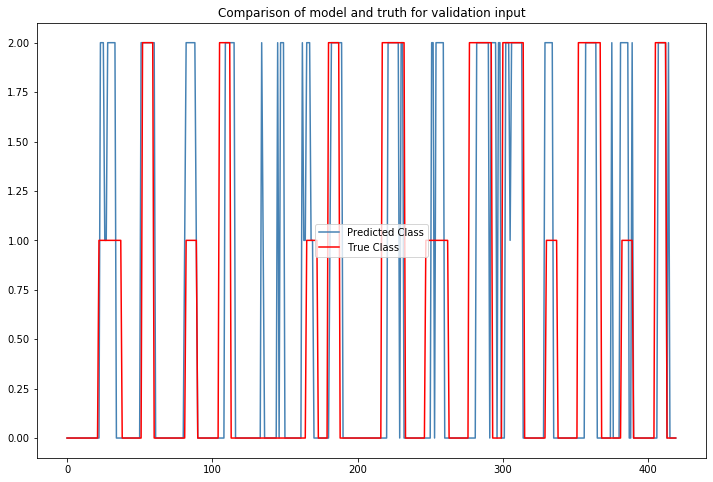

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(pred_final, color='steelblue')
ax.plot(label_final, color='red')
plt.title('Comparison of model and truth for validation input')
plt.legend(['Predicted Class','True Class'])
plt.show()

It's clear that the model is struggling to predict leaving vs entering. Overall, a good start, need more data

## Still a little bit of underfitting
- Areas for improvment
    - ~~More diverse dataset~~ (2020-04-01)
    - Hyperparameter tuning (some improvement 2020-04-04)
    - Make video window overlapping
    - ~~How to freeze some layers?~~ (2020-03-13)

In [29]:
weight_save_path=Path('/media/tris/tris_files/porta3.pth')
torch.save(my_model, weight_save_path)